In [534]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import LogisticRegression

from joblib import dump, load
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
import pandas as pd
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
plt.style.use('seaborn')
%matplotlib inline

pd.set_option('display.max_columns', None)

In [535]:
df=pd.read_parquet('../data/processed/df.parquet')
dfd=pd.read_parquet('../data/processed/dfd.parquet')


In [536]:
dfd.columns

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'df_original', 'id',
       'cut_int', 'color_int', 'clarity_int', 'cut_color_clarity_score',
       'raw_density', 'marketing_carat_int', 'carat_sqr', 'high', 'cut_Fair',
       'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D',
       'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J',
       'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2', 'marketing_carat_bad',
       'marketing_carat_good', 'marketing_carat_regular'],
      dtype='object')

In [537]:
#option 1

# dfd=dfd.drop(columns=['marketing_carat_int','cut_int','color_int', 'clarity_int'])

# #option 2
# dfd=dfd.drop(columns=[ 'marketing_carat_int','cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score'])

# #option 3 espero que sea la mejor
# dfd=dfd.drop(columns=[ 'marketing_carat_int','cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score','x', 'y', 'z'])

# #option 3 bis espero que sea la mejor
# dfd=dfd.drop(columns=[ 'marketing_carat_int','cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score','raw_density'])

# #option 3 bis2 espero que sea la mejor
# dfd=dfd.drop(columns=[ 'marketing_carat_int','cut_int','color_int', 'clarity_int',
#                      'x', 'y', 'z'])

# #option 4
# dfd=dfd.drop(columns=['marketing_carat_int', 'cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score','x', 'y', 'z','raw_density'])

# #option 5 SIN NADA
# dfd=dfd.drop(columns=['marketing_carat_int', 'cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score','raw_density','marketing_carat_bad',
#        'marketing_carat_good', 'marketing_carat_regular'])

#option 5 SIN NADA
dfd=dfd.drop(columns=['marketing_carat_int', 'cut_int','color_int', 'clarity_int',
                     'marketing_carat_bad',
       'marketing_carat_good', 'marketing_carat_regular','carat_sqr','cut_color_clarity_score','raw_density'])

In [538]:
#con carat y 5
# RandomForestRegressor       536.7894862874348
# ExtraTreesRegressor         524.3073747284154
# GradientBoostingRegressor   522.2696670624822
# CatBoostRegressor           515.8518906580055
# LGBMRegressor               520.4246279374379
# XGBRegressor                517.9044507009544
# StackingRegressor           504.8044508186878

#sin carat y 5
# RandomForestRegressor       536.5326496454497
# ExtraTreesRegressor         522.8754833840452
# GradientBoostingRegressor   521.8840694917378
# CatBoostRegressor           514.4646192634776
# LGBMRegressor               520.4418909188064
# XGBRegressor                517.6058680138955
# StackingRegressor           504.43703022069695


df=df.drop(columns=['cut','color', 'clarity','marketing_carat','marketing_carat_int','cut_color_clarity_score','carat_sqr',
                    'raw_density','high'])


#RandomForestRegressor        536.8794322366753
# ExtraTreesRegressor         522.5880641009147
# GradientBoostingRegressor   521.8113311805382
# CatBoostRegressor           515.7005012415111
# LGBMRegressor               520.4246279374379
# XGBRegressor
# StackingRegressor           505.6372856024203

# df=df.drop(columns=['cut','color', 'clarity','marketing_carat','marketing_carat_int','cut_color_clarity_score','carat_sqr'])



In [539]:
df.head()


,carat,depth,table,price,x,y,z,df_original,id,cut_int,color_int,clarity_int
0,1.21,62.4,58.0,4268.0,6.83,6.79,4.25,1,NaN,4,1,4
1,0.32,63.0,57.0,505.0,4.35,4.38,2.75,1,NaN,3,3,4
2,0.71,65.5,55.0,2686.0,5.62,5.53,3.65,1,NaN,1,4,5
3,0.41,63.8,56.0,738.0,4.68,4.72,3.00,1,NaN,2,7,3
4,1.02,60.5,59.0,4882.0,6.55,6.51,3.95,1,NaN,5,4,3


In [540]:
dfd.head()

,carat,depth,table,price,x,y,z,df_original,id,high,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.21,62.4,58.0,4268.0,6.83,6.79,4.25,1,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0.32,63.0,57.0,505.0,4.35,4.38,2.75,1,NaN,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.71,65.5,55.0,2686.0,5.62,5.53,3.65,1,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0.41,63.8,56.0,738.0,4.68,4.72,3.00,1,NaN,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1.02,60.5,59.0,4882.0,6.55,6.51,3.95,1,NaN,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


## Split

In [541]:


df_final=df

data=df_final.loc[df['df_original']==1]

# data=data.loc[(data['carat']>=1.98)]

############## FILAS

# def remove_outlier(df, col):
#     q1 = df[col].quantile(0.25)
#     q3 = df[col].quantile(0.75)
#     iqr = q3-q1 
#     fence_low  = q1-1.5*iqr
#     fence_high = q3+1.5*iqr
#     df_clean = df.loc[(df[col] > fence_low) & (df[col] < fence_high)]
#     return df_clean



# data=data.drop_duplicates(subset=data.columns, keep='first')

data['depth_calc'] = data['z'] / ((data['x'] + data['y'])/2)*100
data['rest']=data['depth_calc'] - data['depth'] 
filter_rest=(data['rest']<-1) | (data['rest']>1)
data=data.loc[~filter_rest]
data=data.drop(columns=['depth_calc','rest'],axis=1)

filter_xyz=(data['x']<0.2) | (data['y']<0.2) | (data['z']<0.2)
data=data.loc[~filter_xyz ]



df_predict=df_final.loc[df['df_original']==0]

X=data.drop(columns=['price','df_original','id'])
Y=data['price']

X_predict=df_predict.drop(columns=['price','df_original','id'])



# rs= StandardScaler()

# rs = RobustScaler() 

# X = pd.DataFrame(rs.fit_transform(X), columns= X.columns)
# X_predict = pd.DataFrame(rs.fit_transform(X_predict), columns= X_predict.columns)


df_predict.to_csv('../data/processed/df_predict.csv',index=False)
X.to_csv('../data/processed/X.csv',index=False)
Y.to_csv('../data/processed/Y.csv',index=False)
X_predict.to_csv('../data/processed/X_predict.csv',index=False)


print(5)
print(data.shape)
print(df_predict.shape)
print(X.shape)
print(X_predict.shape)
display(X)
display(X_predict)


/home/carpiero/miniconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carpiero/miniconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5
(40380, 12)
(13485, 12)
(40380, 9)
(13485, 9)


,carat,depth,table,x,y,z,cut_int,color_int,clarity_int
0,1.21,62.4,58.0,6.83,6.79,4.25,4,1,4
1,0.32,63.0,57.0,4.35,4.38,2.75,3,3,4
2,0.71,65.5,55.0,5.62,5.53,3.65,1,4,5
3,0.41,63.8,56.0,4.68,4.72,3.00,2,7,3
4,1.02,60.5,59.0,6.55,6.51,3.95,5,4,3
...,...,...,...,...,...,...,...,...,...
40450,1.34,62.7,57.0,7.10,7.04,4.43,5,4,5
40451,2.02,57.1,60.0,8.31,8.25,4.73,2,5,2
40452,1.01,62.7,56.0,6.37,6.42,4.01,5,3,3
40453,0.33,61.9,54.3,4.45,4.47,2.76,5,1,5


,carat,depth,table,x,y,z,cut_int,color_int,clarity_int
0,0.79,62.7,60.0,5.82,5.89,3.67,3,5,3
1,1.20,61.0,57.0,6.81,6.89,4.18,5,1,5
2,1.57,62.2,61.0,7.38,7.32,4.57,4,3,3
3,0.90,63.8,54.0,6.09,6.13,3.90,3,5,3
4,0.50,62.9,58.0,5.05,5.09,3.19,3,5,5
...,...,...,...,...,...,...,...,...,...
13480,0.57,61.9,56.0,5.35,5.32,3.30,5,6,3
13481,0.71,62.2,55.0,5.71,5.73,3.56,5,2,4
13482,0.70,61.6,55.0,5.75,5.71,3.53,5,5,5
13483,0.70,58.8,57.0,5.85,5.89,3.45,3,5,2


## Model Generator

In [545]:
# arboles  de decision max_depth probar min sample split
# RandomForestRegressor(max_depth=40, min_samples_split=4, n_estimators=500, random_state=32)
# ('RandomForestRegressor', RandomForestRegressor(max_depth=32, min_samples_split=4, n_estimators=250, random_state=32)),
# max_depth=-1


estimators=[('XGBRegressor' , XGBRegressor(base_score=0.6 ,booster = 'gbtree' ,learning_rate=0.06,max_depth= 6 ,n_estimators=386,n_jobs = -1)),
           ('ExtraTreesRegressor',ExtraTreesRegressor(max_depth=16, min_samples_split=7, n_estimators=509,n_jobs = -1)),
           ('GradientBoostingRegressor',GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,n_estimators=104)),
            ('CatBoostRegressor',CatBoostRegressor(depth = 8, iterations = 1200,silent=True)),
            ('LGBM' , LGBMRegressor( learning_rate =  0.05,n_estimators =  205, max_depth=11,n_jobs = -1,num_leaves=60)),
            
        ]



machine = [
           ExtraTreesRegressor(max_depth=16, min_samples_split=7, n_estimators=509,n_jobs = -1),
           GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,n_estimators=104),
           CatBoostRegressor(depth = 8, iterations = 1200,silent=True),
           LGBMRegressor( learning_rate =  0.05,n_estimators =  205, max_depth=11,n_jobs = -1,num_leaves=60),
           XGBRegressor(base_score=0.6 ,booster = 'gbtree' ,learning_rate=0.06,max_depth= 6 ,n_estimators=386,n_jobs = -1),
          StackingRegressor(estimators=estimators,final_estimator= LinearRegression(n_jobs = -1),
                               cv= 5 , verbose = 10 , passthrough = True),
          ]  


# machine = [  StackingRegressor(estimators=estimators,final_estimator= LinearRegression(n_jobs = -1) ,cv= 5 , 
#                                verbose = 2 , passthrough = True)]  

# LinearRegression(n_jobs = -1)
# ARDRegression(n_iter=1000)

# machine = [ GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,n_estimators=104)]


# lgbm  boosting_type='rf', 
#                        bagging_freq=1, 
#                        bagging_fraction = 0.9





for x in machine:
    print(f'Model in action: {x}\n')
    
#     X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.85, random_state=32)
    
######################           ENTRENAR AL FINAL CON TODO


        
        
#     model = x  
#     model.fit(X_train, Y_train)
    
    
#     predictions_train = model.predict(X_train)#.clip(326,18823)
#     predictions_test = model.predict(X_test)#.clip(326,18823)
 

    
#     print(f' R2 Train: {r2_score(y_true=Y_train, y_pred=predictions_train)}')
#     print(f' R2 Test: {r2_score(y_true=Y_test, y_pred=predictions_test)}')
#     print(f' RMSE = {(mean_squared_error(Y_test, predictions_test,squared=False))}\n\n')
    
    
    model = x  

    
    
    model.fit(X,Y)


    scores = cross_val_score(model, X, Y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    print(f' RMSE_CROSS = {np.mean(-scores)}\n\n')



        # SinROBUSTyConRAWDENSITYyConCARATSQR2
# ExtraTreesRegressor         523.534
# GradientBoostingRegressor   517.786  
# CatBoostRegressor           516.027 
# LGBMRegressor               521.557  
# XGBRegressor                518.264 
# StackingRegressor           505.110 


        # SinROBUSTySinRAWDENSITYyConCARATSQR2
# ExtraTreesRegressor         524.460
# GradientBoostingRegressor   520.599 
# CatBoostRegressor           515.747 
# LGBMRegressor               524.278 
# XGBRegressor                520.474 
# StackingRegressor           506.791

        # SinROBUSTyConRAWDENSITYySinCARATSQR2
# ExtraTreesRegressor         522.318
# GradientBoostingRegressor   517.817
# CatBoostRegressor           515.862
# LGBMRegressor               521.558
# XGBRegressor                518.264
# StackingRegressor           505.278

        # SinROBUSTySinRAWDENSITYySinCARATSQR2
# ExtraTreesRegressor         522.802325537371
# GradientBoostingRegressor   517.8027329518925 
# CatBoostRegressor           514.4090618198663 
# LGBMRegressor               520.575990618077 
# XGBRegressor                519.0832494708653
# StackingRegressor           505.68060485979805


Model in action: ExtraTreesRegressor(max_depth=16, min_samples_split=7, n_estimators=509,
                    n_jobs=-1)

 RMSE_CROSS = 522.802325537371


Model in action: GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,
                          n_estimators=104)

 RMSE_CROSS = 517.8027329518925


Model in action: <catboost.core.CatBoostRegressor object at 0x7feb6ad36790>

 RMSE_CROSS = 514.4090618198663


Model in action: LGBMRegressor(learning_rate=0.05, max_depth=11, n_estimators=205, num_leaves=60)

 RMSE_CROSS = 520.575990618077


Model in action: XGBRegressor(base_score=0.6, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.06, max_delta_step=None, max_depth=6,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=386, n_jobs=-1, n

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   39.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

 RMSE_CROSS = 505.68060485979805




In [546]:
print('TERMINADO')



TERMINADO


## RandomizedSearchCV

In [529]:
# CatBoostRegressor(depth = 8, iterations = 1200,silent=True)

model2= GradientBoostingRegressor()


#  'n_estimators': [16, 32, 64, 128, 256, 500],
#     'min_samples_split': [2, 8, 10, 12],
#     'max_depth' : [2, 4, 8, 10, 16, 32, 50, 75]
# min_samples_split
# min_samples_leaf=1
#leaves

# iterations=None,
#                         learning_rate=None,
#                         depth=None

# 'max_depth' :[4,6,8], 
#     'min_samples_split' :[14,16,18], 
#     'n_estimators':[120,200,300],
#     'min_samples_leaf' : [4,6,8],

param_grid = {
'max_depth' :[7], 
    'min_samples_split' :[17], 
    'n_estimators':[104],
    'min_samples_leaf' : [3],
    'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

}

# Randomized

grid_search = GridSearchCV(model2, 
                                 param_grid, 
                                 cv=5, 
                                 verbose=10, 
                                 scoring='neg_root_mean_squared_error', 
                                 n_jobs=-1,
                                )
# n_iter=32
grid_search.fit(X, Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  1.6min remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.7min finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9],
                         'max_depth': [7], 'min_samples_leaf': [3],
                         'min_samples_split': [17], 'n_estimators': [104]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [530]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 17,
 'n_estimators': 104}

In [531]:
grid_search.best_estimator_
# GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17)

GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,
                          n_estimators=104)

In [532]:
grid_search.best_score_
# --517.8720694843731

-517.7793273283798

## PROBAR RESULTADO

In [319]:
# dfX_test=pd.DataFrame(X_test)
# dfY_test=pd.DataFrame(Y_test)
# dfpredictions_test=pd.DataFrame(predictions_test)
# dftest=pd.concat([dfX_test.reset_index(drop=True),dfY_test.reset_index(drop=True),dfpredictions_test.reset_index(drop=True)], axis=1) 
# dftest.rename(columns={0: 'price_predict'},inplace=True)
# dftest['Diff']=dftest['price']-dftest['price_predict']

# print(dftest['Diff'].describe())
# print(dftest.describe())
# dftest.loc[dftest['Diff']>2000].describe()

count      1.000000
mean     859.061216
std             NaN
min      859.061216
25%      859.061216
50%      859.061216
75%      859.061216
max      859.061216
Name: Diff, dtype: float64


,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,cut_color_clarity_score,raw_density,price,price_predict,Diff
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [547]:
# dump(model, '/home/carpiero/ir/Kaggle/.joblib') 

predictions_competition = model.predict(X_predict)
submission = pd.DataFrame({'id': df_predict['id'], 'price': predictions_competition})
submission['id'] = submission['id'].astype('int64')

# submission.loc[94,'price'] =20631
# submission.loc[94,'price'] =20631


submission.to_csv('/home/carpiero/IRONHACK/kaggle/sin_nada_505_680.csv', index=False)

PROBA=pd.concat([X_predict,submission], axis=1)

# PROBA['price'] = np.where(PROBA['carat']>=2.49,PROBA['price']+PROBA['price']*0.05,PROBA['price'])
# PROBA['price'] = np.where(PROBA['carat']>=3.2,PROBA['price']+PROBA['price']*0.09,PROBA['price'])

# submission=PROBA[['id','price']]

# submission.to_csv('/home/carpiero/IRONHACK/kaggle/SINNADAyaumentandoamano_2_49_05y_3_20_09.csv', index=False)

submission.describe()



,id,price
count,13485.000000,13485.000000
mean,6742.000000,3947.410776
std,3892.928525,3956.282793
min,0.000000,327.610218
25%,3371.000000,936.267406
50%,6742.000000,2449.525412
75%,10113.000000,5288.594664
max,13484.000000,18308.752108


In [548]:

# SinROBUSTyConRAWDENSITYyConCARATSQR2
# count    13485.000000
# mean      3947.999179
# std       3958.699006
# min        163.363126
# 25%        934.982225
# 50%       2464.969051
# 75%       5278.298692
# max      18560.749100
# Name: price, dtype: float64  505.110 

# SinROBUSTySinRAWDENSITYyConCARATSQR2
# count    13485.000000
# mean      3948.926775
# std       3958.269583
# min        330.948345
# 25%        938.487300
# 50%       2455.687555
# 75%       5285.923421
# max      18534.746496
# Name: price, dtype: float64 506.791

# SinROBUSTyConRAWDENSITYySinCARATSQR2

# count    13485.000000
# mean      3947.837618
# std       3957.962843
# min        338.634208
# 25%        935.633835
# 50%       2452.391613
# 75%       5289.271769
# max      18374.874823
# Name: price, dtype: float64  505.278

#getdumies
# count    13485.000000
# mean      3948.839011
# std       3958.164000
# min        318.942978
# 25%        944.366057
# 50%       2444.931991
# 75%       5297.687753
# max      18902.506381
# Name: price, dtype: float64

#SinROBUSTySinRAWDENSITYySinCARATSQR2
# count    13485.000000
# mean      3947.396160
# std       3956.301710
# min        323.516320
# 25%        936.455943
# 50%       2446.378377
# 75%       5292.367311
# max      18360.274125
# Name: price, dtype: float64   506.345

#con high

# count    13485.000000
# mean      3947.695348
# std       3955.700575
# min        331.610443
# 25%        940.324036
# 50%       2453.506270
# 75%       5295.485017
# max      18500.671094
# Name: price, dtype: float64

#SinROBUSTySinRAWDENSITYySinCARATSQR2
# count    13485.000000
# mean      3947.410776
# std       3956.282793
# min        327.610218
# 25%        936.267406
# 50%       2449.525412
# 75%       5288.594664
# max      18308.752108
# Name: price, dtype: float64


PROBA['price'].describe()

count    13485.000000
mean      3947.410776
std       3956.282793
min        327.610218
25%        936.267406
50%       2449.525412
75%       5288.594664
max      18308.752108
Name: price, dtype: float64

In [478]:
PROBA.loc[(PROBA['price']>18000) | (PROBA['price']<0)  | (PROBA['carat']>2.9)  ].sort_values(by='price',  ascending=False)

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,id,price
7336,0.51,61.8,54.7,5.12,5.15,31.80,3,6,5,7336,100779.294364
1665,0.51,61.8,55.0,5.15,31.80,5.12,5,6,5,1665,69805.383704
9724,2.29,61.4,60.0,8.45,8.49,5.20,4,1,8,9724,18994.788115
2901,1.20,62.1,59.0,0.00,0.00,0.00,4,7,7,2901,18969.933877
94,5.01,65.5,59.0,10.74,10.54,6.98,1,1,1,94,18812.989506
1025,2.14,60.3,60.0,8.31,8.43,5.05,3,7,2,1025,18559.875603
3022,2.01,62.7,57.0,8.03,8.11,5.06,3,6,3,3022,18315.487600
4572,2.01,58.7,59.0,8.23,8.27,4.84,2,6,3,4572,18271.881970
9091,2.29,60.8,60.0,8.47,8.50,5.16,4,2,4,9091,18182.081084
6925,2.29,61.6,60.0,8.45,8.43,5.20,4,3,4,6925,18160.507043


In [479]:
PROBA.loc[(PROBA['cut_int']==1) & (PROBA['clarity_int']==1)  & (PROBA['color_int']==1)  ]

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,id,price
94,5.01,65.5,59.0,10.74,10.54,6.98,1,1,1,94,18812.989506
6418,2.72,68.2,56.0,8.46,8.43,5.76,1,1,1,6418,9301.757581
6608,0.70,64.7,59.0,5.59,5.50,3.59,1,1,1,6608,5378.319719
6668,0.96,59.5,60.0,6.28,6.23,3.72,1,1,1,6668,5641.660171


In [374]:
PROBA.loc[(PROBA['price']>18000) | (PROBA['price']<0)].describe()

,carat,depth,table,cut_int,color_int,clarity_int,id,price
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,2.102727,61.072727,58.909091,3.727273,4.181818,4.272727,7188.545455,18181.713093
std,0.223968,0.852163,2.385563,0.786245,1.887760,2.053821,4615.671725,128.955322
min,1.700000,59.600000,53.000000,3.000000,1.000000,2.000000,407.000000,18013.806236
25%,2.025000,60.650000,59.000000,3.000000,3.500000,2.500000,2764.500000,18097.213085
50%,2.140000,61.300000,60.000000,4.000000,4.000000,4.000000,9468.000000,18142.128533
75%,2.275000,61.600000,60.000000,4.000000,5.000000,5.500000,10554.500000,18230.278320
max,2.420000,62.400000,61.000000,5.000000,7.000000,8.000000,12782.000000,18429.692685


In [480]:
ct=1.98


In [481]:
# count       90.000000
# mean     15627.380493
# std       2002.732916
# min       7995.524075
# 25%      14964.466748
# 50%      16112.883947
# 75%      16657.651248
# max      18359.051088
# Name: price, dtype: float64

#con high
# count       90.000000
# mean     15585.970692
# std       1945.263487
# min       8408.464553
# 25%      14908.559693
# 50%      16024.381252
# 75%      16592.274384
# max      18500.671094
# Name: price, dtype: float64

# 1.98
# count      512.000000
# mean     15022.298750
# std       2072.747771
# min       6166.998184
# 25%      13960.571738
# 50%      15516.758186
# 75%      16452.486691
# max      18429.692685
# Name: price, dtype: float64


PROBA['price'].loc[(PROBA['carat']>=ct)].describe()

count      512.000000
mean     15035.043642
std       2116.864262
min       6493.533862
25%      13911.252712
50%      15466.519208
75%      16513.211716
max      18994.788115
Name: price, dtype: float64

In [376]:
# count    13395.000000
# mean      3868.933770
# std       3848.184557
# min        323.689995
# 25%        933.160547
# 50%       2419.907418
# 75%       5226.899091
# max      18283.119989
# Name: price, dtype: float64

#con high

# count    13395.000000
# mean      3869.498649
# std       3848.546187
# min        331.610443
# 25%        936.507781
# 50%       2421.647628
# 75%       5238.367114
# max      18349.737579
# Name: price, dtype: float64



PROBA['price'].loc[(PROBA['carat']<ct)].describe()

count    13395.000000
mean      3872.820254
std       3852.225315
min        335.978528
25%        929.400185
50%       2416.021805
75%       5235.493586
max      18266.419324
Name: price, dtype: float64

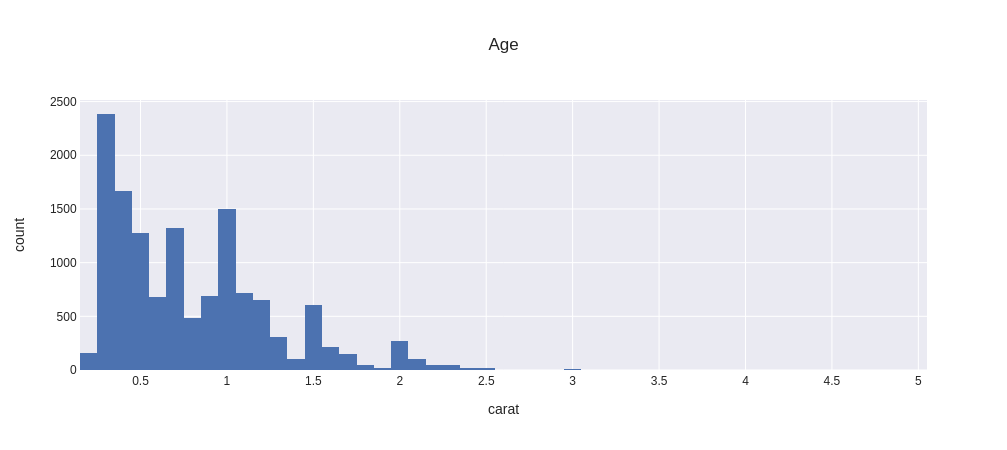

In [550]:
fig=px.histogram(PROBA, x='carat',nbins=50,template='seaborn',title='Age',barmode='group')
fig.show()

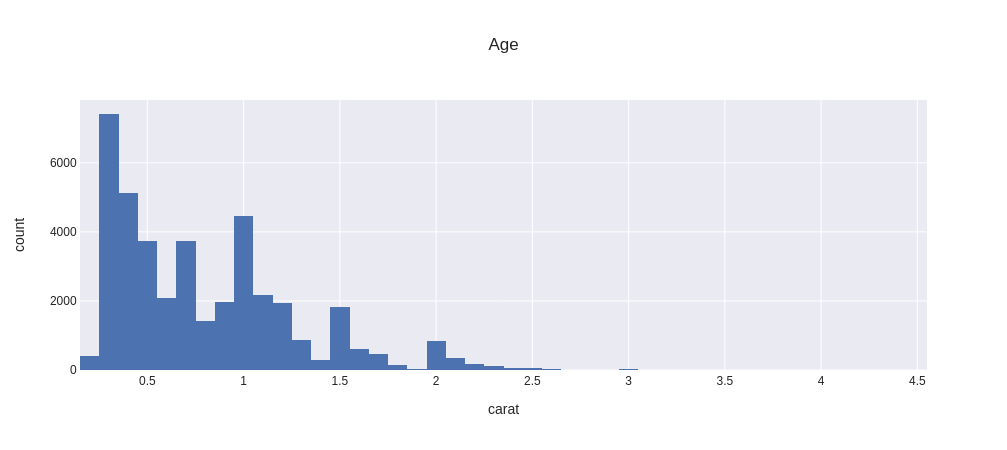

In [549]:
fig=px.histogram(X, x='carat',nbins=50,template='seaborn',title='Age',barmode='group')
fig.show()

In [553]:
PROBA.loc[(PROBA['carat']>=1.25)].describe()

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,id,price
count,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000
mean,1.663757,61.768988,58.064260,7.557565,7.545572,4.662842,3.738180,3.396543,3.392984,6682.883071,11319.103797
std,0.328362,1.585708,2.232086,0.506850,0.501482,0.326964,1.121818,1.682701,1.380953,3875.210297,3605.745422
min,1.250000,50.800000,51.600000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2969.375641
25%,1.500000,60.900000,57.000000,7.230000,7.220000,4.470000,3.000000,2.000000,2.000000,3288.000000,8395.364570
50%,1.540000,61.900000,58.000000,7.430000,7.430000,4.590000,4.000000,3.000000,3.000000,6697.000000,11229.220153
75%,2.000000,62.600000,59.000000,7.920000,7.890000,4.880000,5.000000,5.000000,4.000000,9848.500000,14403.653834
max,5.010000,68.300000,69.000000,10.740000,10.540000,6.980000,5.000000,7.000000,8.000000,13479.000000,18308.752108


In [377]:
PROBA.loc[(PROBA['carat']>=3.20)]

,carat,depth,table,cut_int,color_int,clarity_int,id,price
94,5.01,65.5,59.0,1,1,1,94,17636.189685
9838,3.65,67.1,53.0,1,3,1,9838,14696.201377
12305,3.67,62.4,56.0,4,2,1,12305,14156.555556
